## Chest CT Scan Images Analysis

In [2]:
#Import libraries
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import zipfile

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [3]:
#Import Google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir -p /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"---------------","key":"-------------------------"}')
    #Be able to access Kaggle files

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=e7f25db7537b6891205d08e0c84f66a62a4d63885060ea76a3de89b6f8107f39
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [5]:
# commands to download data from kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images
!mkdir -p "/content/data"

!unzip -qo "chest-ctscan-images.zip" -d "/content/data"

 99% 118M/119M [00:06<00:00, 23.7MB/s]
100% 119M/119M [00:06<00:00, 19.3MB/s]


In [6]:
#Define Data Transforms
data_transforms = {
   "train": transforms.Compose([
       transforms.RandomResizedCrop(224),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   ]),
   "valid": transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   ]),
   "test": transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   ]),
}

In [7]:
#Create Dataset Instances
data_dir = "/content/data/Data"

image_datasets = {
   "train": ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
   "valid": ImageFolder(os.path.join(data_dir, "valid"), data_transforms["valid"]),
   "test": ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"]),
}

In [8]:
#Create Data Loaders
batch_size = 64

dataloaders = {
   "train": DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True),
   "valid": DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False),
   "test": DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=False),
}

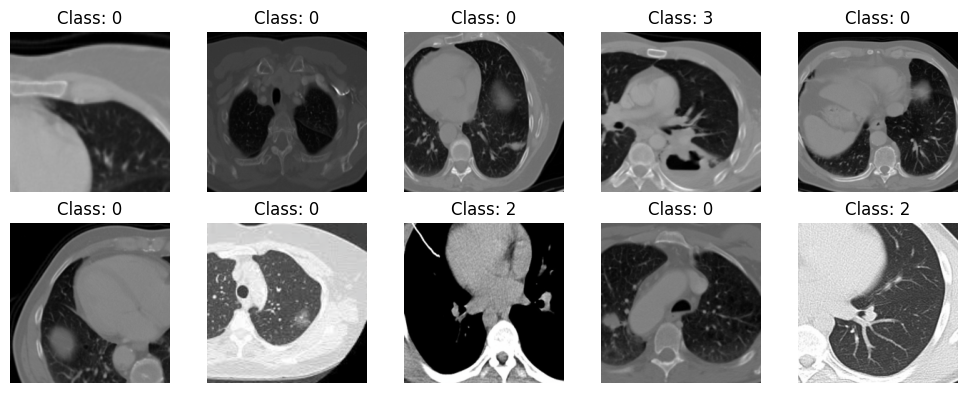

In [9]:
#Get a batch of 10 images to display
batch_size = 10
sample_loader = DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True)
images, labels = next(iter(sample_loader))

#Display the images in rows of 5
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2* num_rows))
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        image = images[index].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Class: {labels[index].item()}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [10]:
#Define the ResNet-101 model
def create_resnet_model(num_classes):
    model = models.resnet101(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [11]:
#Initialize the model
num_classes = len(image_datasets["train"].classes)
model = create_resnet_model(num_classes)

#Set the model to training mode
model.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:07<00:00, 23.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
#Define the loss function
criterion = nn.CrossEntropyLoss()
#Choose an optimization
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Training and evaluation loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0

    #Create a progress bar for the training epoch
    progress_bar = tqdm(enumerate(dataloaders["train"]), total=len(dataloaders["train"]), desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", leave=False)

    for batch_idx, (inputs, labels) in progress_bar:
        #Zero the parameter gradients
        optimizer.zero_grad()
        #Forward pass
        outputs = model(inputs)
        #Compute the loss
        loss = criterion(outputs, labels)
        #Backward pass and optimization
        loss.backward()
        optimizer.step()
        #Update the running loss
        running_loss += loss.item()
        #Update the progress bar description
        progress_bar.set_postfix(loss=loss.item())

    #Close the progress
    progress_bar.close()

    #Calculate training accuracy for the epoch
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders["valid"]:
            #Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            #Collect predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #Calculate training accuracy for the epoch
    accuracy = accuracy_score(all_labels, all_predictions)

    #Print training loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloaders["train"])
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.3262, Accuracy: 34.72%


Epoch 2/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.1085, Accuracy: 38.89%


Epoch 3/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9955, Accuracy: 36.11%


Epoch 4/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8724, Accuracy: 41.67%


Epoch 5/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.8548, Accuracy: 45.83%


Epoch 6/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7568, Accuracy: 66.67%


Epoch 7/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7085, Accuracy: 66.67%


Epoch 8/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6991, Accuracy: 63.89%


Epoch 9/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7488, Accuracy: 51.39%


Epoch 10/10 (Training):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6853, Accuracy: 58.33%


In [13]:
model.eval()
#Create lists to store predicted labels and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        #Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        #Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 59.68%
